In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import  re
from transformers import pipeline, AutoTokenizer, TFAutoModelForSequenceClassification

In [150]:
# Load datasets
orders = pd.read_csv('orders.csv')
reviews = pd.read_csv('order_reviews.csv')
products = pd.read_csv('products.csv')
order_items = pd.read_csv('order_items.csv')

In [151]:
# Drop empty values from reviews
reviews.dropna(subset=['review_comment_message'], inplace=True)

In [152]:
# Initialize the model
model = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

C:\Users\mikja\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassificat

In [153]:
# Function to extract sentiment score from the reviews
def extract_sentiment_score(text):
    result = model(text)
    return int(result[0]['label'][0:2])

# Function to extract price mentions
def extract_price_mentions(text):
    prices = re.findall(r'\b\d+\.?\d*\b', text)
    return prices if prices else []

"""
I don't know how can I extract the price differently, I could do a lot of "IF's" and eventually get more consistent,
instead of getting all the digits from comments, but I'm not sure if that's the point..
"""

'\nI don\'t know how can I extract the price differently, I could do a lot of "IF\'s" and eventually get more consistent,\ninstead of getting all the digits from comments, but I\'m not sure if that\'s the point..\n'

In [154]:
len(reviews)

41753

In [155]:
new_reviews = reviews.iloc[:1000]

#### At this point, I think that I may have done something wrong, but applying the model takes a very long time. Extracting sentiment score from only 100 cells takes approx. 1 minute, which means that doing that for the whole dataset would take ~7 hours. I've decided that I will only do it for 1000 cells. Despite carrying out the analysis on such a small number of records, I believe that the task is still done correctly

In [156]:
# Extract sentiment score
new_reviews['sentiment_score'] = new_reviews['review_comment_message'].apply(extract_sentiment_score)
# Extract price
new_reviews['price_mentions'] = new_reviews['review_comment_message'].apply(extract_price_mentions)

# Map sentiment scores to overall sentiment categories
sentiment_mapping = {5: 'Positive', 
                     4: 'Positive', 
                     3: 'Neutral',  
                     2: 'Negative',
                     1: 'Negative'}

new_reviews['sentiment'] = new_reviews['sentiment_score'].map(sentiment_mapping)

C:\Users\mikja\AppData\Local\Temp\ipykernel_9464\4154384932.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_reviews['sentiment_score'] = new_reviews['review_comment_message'].apply(extract_sentiment_score)
C:\Users\mikja\AppData\Local\Temp\ipykernel_9464\4154384932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_reviews['price_mentions'] = new_reviews['review_comment_message'].apply(extract_price_mentions)
C:\Users\mikja\AppData\Local\Temp\ipykernel_9464\4154384932.py:13: SettingWithCopyWarn

In [157]:
# Merge dataframes
df = new_reviews.merge(orders, on='order_id').merge(order_items, on='order_id').merge(products, on='product_id')

# Correlation of text comments with a numerical rating 

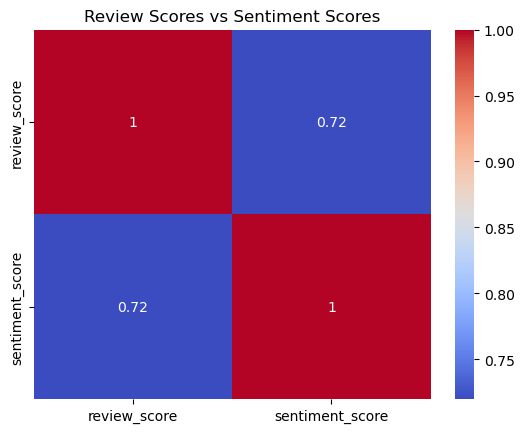

In [158]:
# Correlation matrix
correlation_matrix = df[['review_score', 'sentiment_score']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Review Scores vs Sentiment Scores')
plt.show()

As I mentioned earlier, only 1000 records were used for the analysis, but despite this, the correlation coefficient is approximately 0,7.
Correlation coefficients whose magnitude are between 0,7 and 0,9 indicate variables which can be considered highly correlated.
That means that - if review scores are higher, sentiment scores will be higher too (works both ways obviously).

# Products with the best/worst reviews

In [159]:
best_products = data.groupby('product_id')['review_score'].mean().nlargest(10)
worst_products = data.groupby('product_id')['review_score'].mean().nsmallest(10)

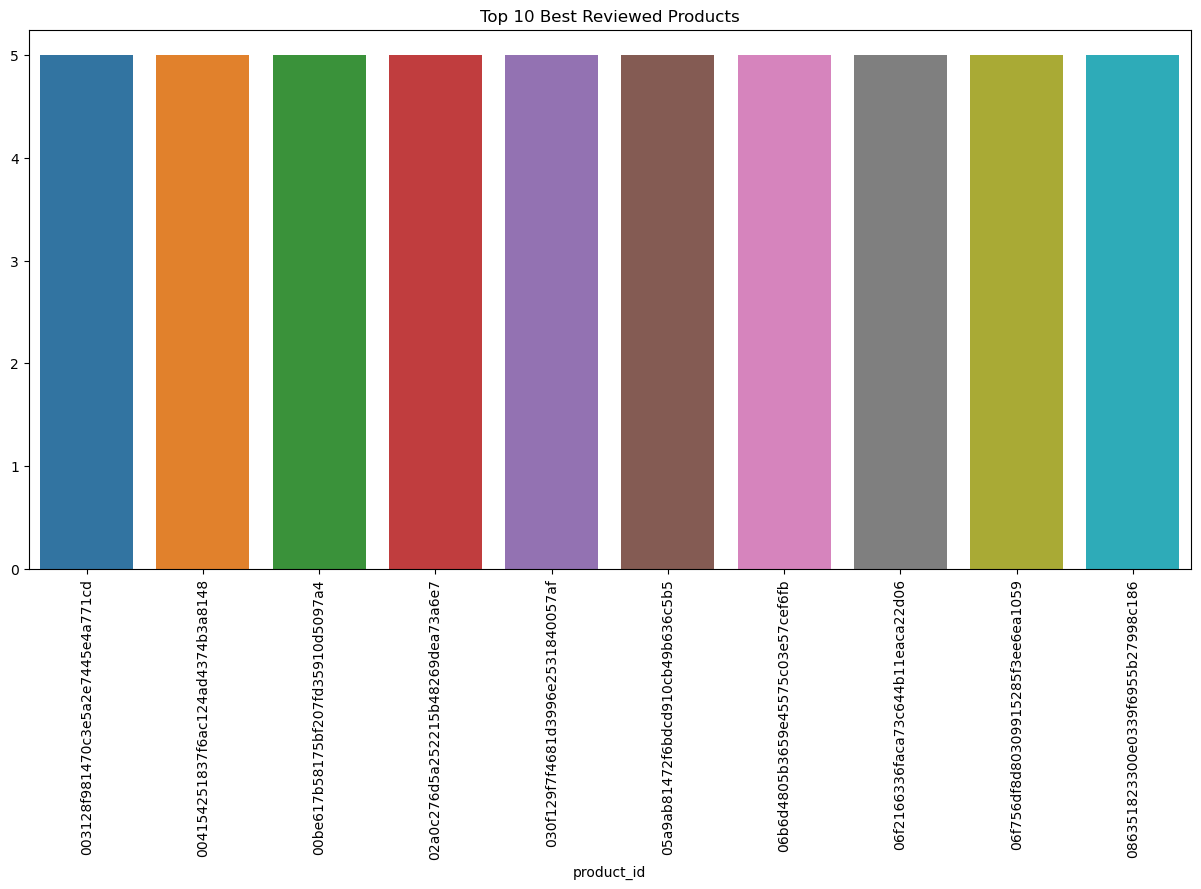

In [160]:
plt.figure(figsize=(15, 7))
sns.barplot(x=best_products.index, y=best_products.values)
plt.title('Top 10 Best Reviewed Products')
plt.xticks(rotation=90)
plt.show()

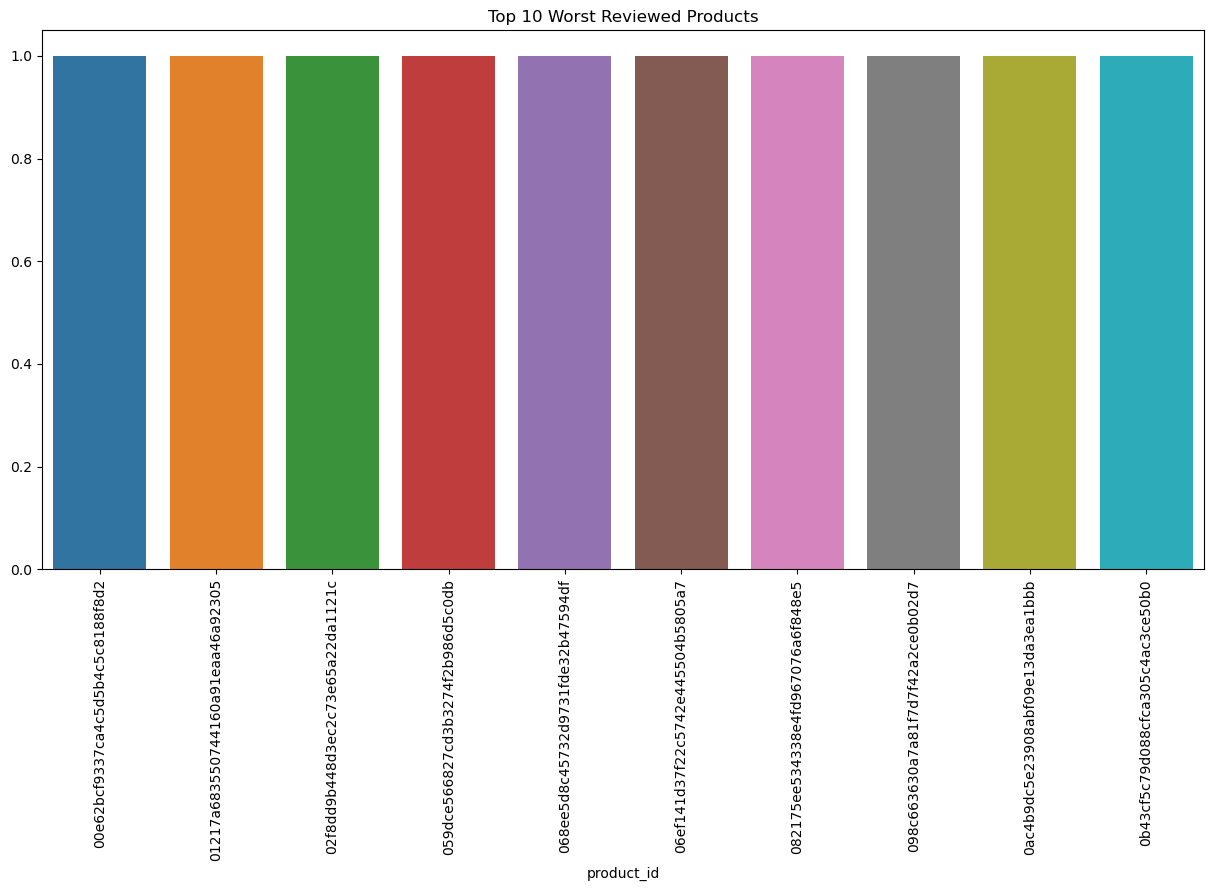

In [161]:
plt.figure(figsize=(15, 7))
sns.barplot(x=worst_products.index, y=worst_products.values)
plt.title('Top 10 Worst Reviewed Products')
plt.xticks(rotation=90)
plt.show()

# Sellers who only collect negative feedback

In [162]:
negative_sellers = data[data['sentiment'] == 'Negative']['seller_id'].unique()
print('Sellers who collect only negative feedback:')
for count, i in enumerate(negative_sellers):
    print(f"{count}: {i}")

Sellers who collect only negative feedback:
0: a1043bafd471dff536d0c462352beb48
1: 7ddcbb64b5bc1ef36ca8c151f6ec77df
2: 0be8ff43f22e456b4e0371b2245e4d01
3: 7142540dd4c91e2237acb7e911c4eba2
4: 54965bbe3e4f07ae045b90b0b8541f52
5: 634964b17796e64304cadf1ad3050fb7
6: 318f287a62ab7ac10b703ac37435a231
7: d20b021d3efdf267a402c402a48ea64b
8: 128639473a139ac0f3e5f5ade55873a5
9: 8b321bb669392f5163d04c59e235e066
10: a7f13822ceb966b076af67121f87b063
11: aac29b1b99776be73c3049939652091d
12: 53e4c6e0f4312d4d2107a8c9cddf45cd
13: 78c99c6dff4eeae5be99bf635ed21e3f
14: fffd5413c0700ac820c7069d66d98c89
15: 5656537e588803a555b8eb41f07a944b
16: 8cbac7e12637ed9cffa18c7875207478
17: bbad7e518d7af88a0897397ffdca1979
18: 784ba75dd9d20200c4caed3d7a77141a
19: 5dceca129747e92ff8ef7a997dc4f8ca
20: 7f2617c58d5d06806987308b45654351
21: 4a3ca9315b744ce9f8e9374361493884
22: b372ee768ed69e46ca8cdbd267aa7a38
23: 0241d4d5d36f10f80c644447315af0bd
24: c31eff8334d6b3047ed34bebd4d62c36
25: 4869f7a5dfa277a7dca6462dcf3b52b2
26: 

# Comment classifier

In [163]:
def comment_classifier(comment):
    sentiment = model(comment)[0]['label']
    return sentiment

In [164]:
comment_1 = "Genius, Can't recommend it more!"
sentiment_mapped = sentiment_mapping[int(comment_classifier(comment_1)[0:2])]
print(f"Looks like the comment is {sentiment_mapped}")
print("Sentiment for given comment:", comment_classifier(comment_1))

Looks like the comment is Positive
Sentiment for given comment: 5 stars


In [165]:
comment_2 = "Horrible customer care, it's been 3 months and I didn't get the product!"
sentiment_mapped = sentiment_mapping[int(comment_classifier(comment_2)[0:2])]
print(f"Looks like the comment is {sentiment_mapped}")
print("Sentiment for given comment:", comment_classifier(comment_2))

Looks like the comment is Negative
Sentiment for given comment: 1 star


In [166]:
comment_3 = "Meh, could be better"
sentiment_mapped = sentiment_mapping[int(comment_classifier(comment_3)[0:2])]
print(f"Looks like the comment is {sentiment_mapped}")
print("Sentiment for given comment:", comment_classifier(comment_3))

Looks like the comment is Neutral
Sentiment for given comment: 3 stars


# After word

For this project, I've decided to go with the easy approach. More detailed way would be to make a better data exploration (provide some conclusions, visual informations like bar charts, word clouds etc.), data preprocessing (stop words, regular expressions, lemmatization, stemming), feature engineering (TF-IDF, GloVe embeddings, etc.) and Classification Models.
In general, exercise like this can have milion different ways to complete it, but due to lack of time and hurry I've decided to go with the simple one.